# Домашнее задание по аномалиям.

В этом задании вам нужно будет исследовать данные (ml5.csv) по сердечно-сосудистым заболеваниям. Данные из соревнования, которое проходило несколько лет назад. Таргет 'cardio' принимает бинарные значения.

Итак, что нужно сделать:

1. Это соревнование отличалось большим количеством сорных или аномальных данных. Вам нужно постараться что-то с ними сделать - локализовать и исправить, или удалить, или оставить как есть.
2. Вам нужно проверить, растет ли скор на валидации при исправлении тех или иных аномалий. 
3. Попробуйте разные способы борьбы и поиска аномалий. Опишите все шаги и что помогло повысить скор, а что нет.
4. Выбор модели на ваше усмотрение, можете попробовать разные.
5. Максимально все комментируйте и наглядно показывайте, это исследовательская работа. 

In [1]:
import numpy as np
import pandas as pd
import random
import math
import sklearn.datasets as ds
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline

In [2]:
# считаем данные
X_full = pd.read_csv('ml5.csv', sep=';', index_col=0)

In [3]:
X_full.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
X_full.isnull().sum().sum() # посмотрим есть ли пропущенные значения

0

Пропущенных значений нет

In [5]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


Числовые типы данных. Есть категориальные признаки, но они уже закодированы.

In [6]:
print("Min age = {}, max age = {} (days)".format(min(X_full.age), max(X_full.age)))
print("Min age = {:.4f}, max age = {:.4f} (years)".format(min(X_full.age)/365, max(X_full.age)/365))

Min age = 10798, max age = 23713 (days)
Min age = 29.5836, max age = 64.9671 (years)


Исходя из данных, будем читать, что возраст дан в днях. Нижняя строка -- перевод в года. Вполне адекватные цифры.

In [7]:
X_full.cardio.value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

Выборка сбалансирована

In [8]:
y_full = X_full.cardio     # создадим целевую переменную 
X_full.drop('cardio', axis=1, inplace=True)

Решим задачу классификации

Поделим выборку на обучающую, валидационную и тестовую.

In [9]:
X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [10]:
X.head(1)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
67617,21876,1,154,80.0,130,90,2,1,0,0,1


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
rf = RandomForestClassifier(random_state=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("AUC = {:.4f}".format(roc_auc_score(y_val, y_pred)))

/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC = 0.7032


# Работа с данными вручную

In [14]:
X_numbers_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

In [15]:
def pair_plot(X_data):
    sns.pairplot(pd.DataFrame(X_data[X_numbers_features]))

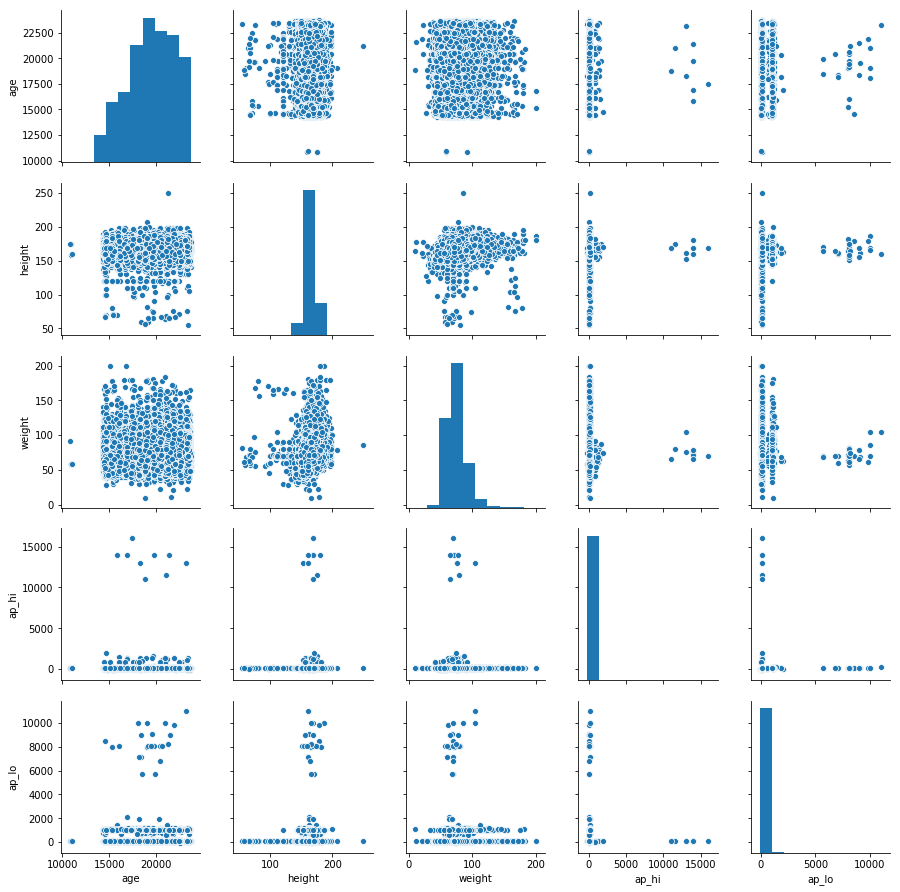

In [16]:
pair_plot(X_full)

Видно, что есть выбросы. Попробуем найти опечатки. Временно вернем столбец таргета.

In [17]:
X_hand = X_full.copy()
X_hand['cardio'] = y_full

In [18]:
cols = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
for i in cols:
    print(i, set(X_full[i]), sep=': ')

gender: {1, 2}
cholesterol: {1, 2, 3}
gluc: {1, 2, 3}
smoke: {0, 1}
alco: {0, 1}
active: {0, 1}


В категориальных признаках явных опечаток нет

Поработаем со столбцами ap_hi и ap_lo:


In [19]:
X_hand[(X_hand.ap_hi<0) | (X_hand.ap_lo<0)]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
6525,15281,1,165,78.0,-100,80,2,1,0,0,1,0
22881,22108,2,161,90.0,-115,70,1,1,0,0,1,0
29313,15581,1,153,54.0,-100,70,1,1,0,0,1,0
34295,18301,1,162,74.0,-140,90,1,1,0,0,1,1
36025,14711,2,168,50.0,-120,80,2,1,0,0,0,1
50055,23325,2,168,59.0,-150,80,1,1,0,0,1,1
66571,23646,2,160,59.0,-120,80,1,1,0,0,0,0
85816,22571,1,167,74.0,15,-70,1,1,0,0,1,1


In [20]:
X_hand[X_hand.ap_hi<X_hand.ap_lo].head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
314,17489,2,183,98.0,160,1100,1,2,1,0,1,1
334,21932,2,157,60.0,160,1000,2,1,0,0,0,1
357,18217,1,150,83.0,140,800,1,1,0,0,1,1
458,23407,1,176,63.0,160,1000,2,2,0,0,0,1
482,18704,1,154,81.0,140,1000,2,1,0,0,1,1
680,15226,1,150,95.0,150,1033,1,1,0,0,1,1
681,19099,1,156,65.0,120,150,2,1,0,0,1,0
805,20430,2,173,101.0,200,1000,1,1,0,0,1,1
815,21281,1,168,78.0,14,90,2,1,0,0,1,1


Видно, что есть 3 вида опечаток в столбцах ap_hi и ap_lo:
1. Отрицательное давление
2. Продублирована последняя цифра в столбце ap_lo
3. Не дописан 0 в столбце ap_hi

Исправим эти опечатки, чтобы не выбрасывать более 1200 строк

In [21]:
X_hand.ap_hi = np.abs(X_hand.ap_hi)
X_hand.ap_lo = np.abs(X_hand.ap_lo)

In [22]:
# убираем лишние знаки в столбце ap_lo

while len(X_hand[X_hand['ap_lo'] >= 300]):
    X_hand.loc[X_hand['ap_lo'] >= 300, 'ap_lo'] //= 10

In [23]:
X_hand.loc[(X_hand['ap_hi']<X_hand['ap_lo']) & (X_hand['ap_hi'] <= 20), 'ap_hi'] *= 10

In [24]:
X_hand[(X_hand['ap_hi'] < X_hand['ap_lo'])].head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
681,19099,1,156,65.0,120,150,2,1,0,0,1,0
913,20457,2,169,68.0,70,110,1,1,0,0,1,0
3356,23361,1,154,102.0,90,150,1,1,0,0,0,1
4214,21957,2,182,90.0,80,140,3,3,0,0,1,1
4880,19992,2,180,80.0,80,125,3,3,1,1,1,1


В этих строках перепутаны значения ap_hi и ap_lo. Поменяем их местами

In [25]:
ind = list(X_hand[X_hand.ap_hi<X_hand.ap_lo].index)  # строки, в которых  ap_hi < ap_lo
X_hand.loc[ind, 'ap_hi'], X_hand.loc[ind, 'ap_lo'] = X_hand.loc[ind, 'ap_lo'], X_hand.loc[ind, 'ap_hi']

In [26]:
X_hand.loc[ind,:].head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
681,19099,1,156,65.0,150,120,2,1,0,0,1,0
913,20457,2,169,68.0,110,70,1,1,0,0,1,0
3356,23361,1,154,102.0,150,90,1,1,0,0,0,1
4214,21957,2,182,90.0,140,80,3,3,0,0,1,1
4880,19992,2,180,80.0,125,80,3,3,1,1,1,1


Найдены явные опечатки.

Снова разделим данные на 3 части.

In [27]:
y_hand = X_hand.cardio     # создадим целевую переменную 
X_hand.drop('cardio', axis=1, inplace=True)

In [28]:
X, X_test, y, y_test = train_test_split(X_hand, y_hand, test_size=0.2, random_state=42)

In [29]:
X.head(1)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
67617,21876,1,154,80.0,130,90,2,1,0,0,1


In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
rf3 = RandomForestClassifier(random_state=15)
rf3.fit(X_train, y_train)
y3_pred = rf3.predict(X_val)
print("AUC = {:.4f}".format(roc_auc_score(y_val, y3_pred)))

/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC = 0.7068


Качество улучшилось по сравнению с необработанными данными.


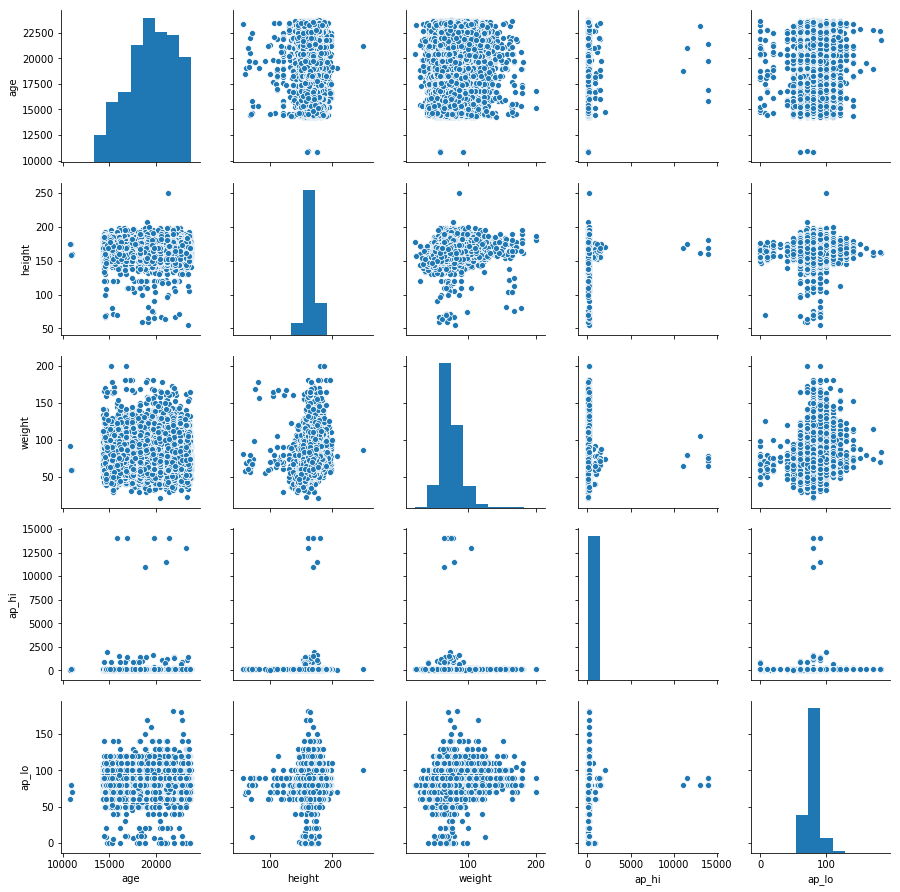

In [32]:
pair_plot(X)

Уберем некоторые выбросы

In [33]:
X_train['cardio'] = y_train

/home/tgorlenko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
X_train[X_train['ap_hi'] <= 50]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
36325,17952,2,176,73.0,12,0,1,1,0,0,1,0
75007,21919,1,155,66.0,13,0,1,1,0,0,1,0


In [35]:
ind = X_train[X_train['ap_hi'] <= 50].index
X_train.drop(labels=ind, axis=0, inplace=True)

/home/tgorlenko/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:
X_train[X_train['ap_hi'] <= 50]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,


In [37]:
X_train[X_train['ap_hi']>260]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
66998,16910,2,180,78.0,14020,90,1,1,0,0,1,1
59301,20970,1,154,41.0,806,0,1,1,0,0,1,0
73356,18784,2,168,65.0,11020,80,1,1,0,0,1,1
6822,14425,1,168,63.0,909,60,2,1,0,0,1,0
61725,23418,1,165,67.0,1420,80,2,1,0,0,1,1
79679,23182,1,161,105.0,13010,80,1,1,0,0,0,0
42410,17548,1,154,65.0,907,70,1,1,0,0,1,0
72539,16918,2,164,66.0,1409,90,1,1,0,0,1,1
40239,19700,2,175,87.0,1620,80,2,1,0,0,1,1


In [38]:
X_train[X_train['ap_lo'] == 0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
91073,14722,2,161,61.0,117,0,1,1,0,0,1,0
59301,20970,1,154,41.0,806,0,1,1,0,0,1,0
32749,21182,2,166,68.0,149,0,1,1,0,0,1,1
62754,18802,1,164,78.0,108,0,2,1,0,0,1,0
2845,22712,2,167,59.0,906,0,1,1,0,0,1,0
19258,14965,2,150,60.0,130,0,1,1,0,0,0,0
23512,20457,1,156,50.0,138,0,3,1,0,0,1,1
81298,15268,1,164,70.0,120,0,1,1,0,0,1,0
34120,16131,1,161,92.0,906,0,2,1,0,0,1,1


Странные данные. Есть множество вариантов трактования. Поэтому исправить их тяжело, удалим эти строки.

In [39]:
ind = X_train[(X_train['ap_hi'] > 260) | (X_train['ap_lo'] == 0)].index
X_train.drop(labels=ind, axis=0, inplace=True)

In [40]:
y_train = X_train.cardio     # создадим целевую переменную 
X_train.drop('cardio', axis=1, inplace=True)
X_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
19196,21407,1,169,65.0,120,80,1,2,0,0,1
741,21161,2,170,65.0,120,80,1,1,1,0,1
40699,23325,2,163,65.0,120,80,2,1,0,0,1
38503,18885,2,160,64.0,120,70,1,1,0,0,1
68235,20305,1,148,73.0,140,90,3,1,0,0,1


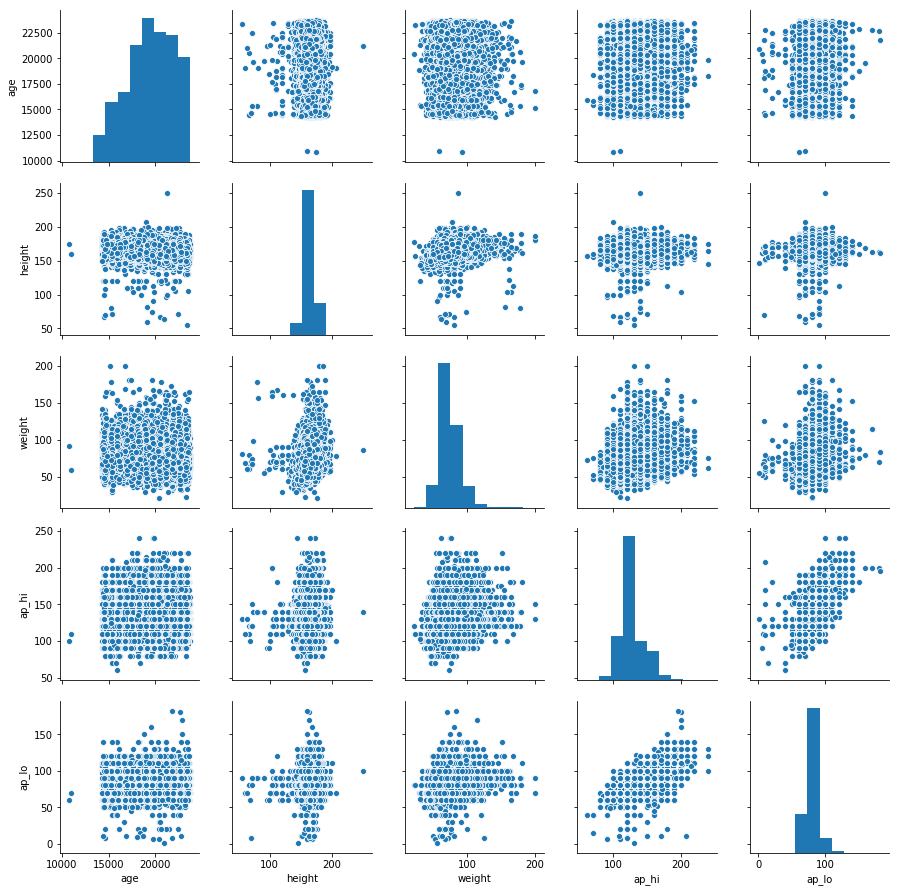

In [41]:
pair_plot(X_train)

Распределение стало лучше

In [42]:
rf = RandomForestClassifier(random_state=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("AUC = {:.4f}".format(roc_auc_score(y_val, y_pred)))

/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC = 0.7019


Качество на валидационной выборке стало хуже. Но в обучающей выборке уменьшилось число строк -- удалили явные выбросы

# Статистические методы

Попробуем применить статистические методы.


## Z-score

In [43]:
def delete_outliers_statistic(X_data, y_data, y_label):
    X_transform = X_data.copy()
    X_transform['y_label'] = y_label.copy()
    X_transform['cardio'] = y_data

    X_transform = X_transform[X_transform['y_label'] == 0].reset_index(drop=True).drop('y_label', axis=1)

    y_transform = X_transform['cardio']
    X_transform.drop('cardio', axis=1, inplace=True)
    
    print("old shape = ", X_data.shape)
    print("new shape = ", X_transform.shape)
    return X_transform, y_transform

In [44]:
ss = StandardScaler()
ss.fit(X_train.astype(float))
X_train_ss = ss.transform(X_train.astype(float))

In [45]:
outliears_ind = (X_train_ss < -3).astype(int).sum(axis=1) + (X_train_ss > 3).astype(int).sum(axis=1) > 0
y_pred = outliears_ind.astype(int)

In [46]:
X_train_zscore, y_train_zscore = delete_outliers_statistic(X_train, y_train, y_pred)

old shape =  (44767, 11)
new shape =  (35498, 11)


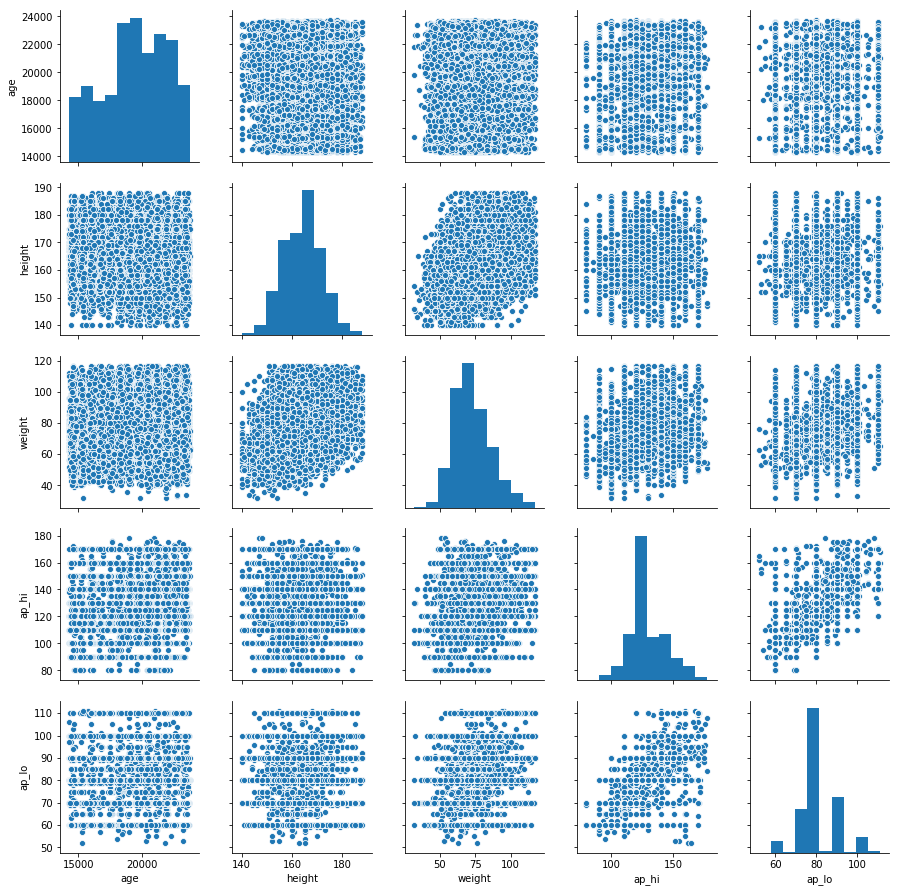

In [47]:
pair_plot(X_train_zscore)

In [48]:
rf = RandomForestClassifier(random_state=15)
rf.fit(X_train_zscore, y_train_zscore)
y_pred = rf.predict(X_val)
print("AUC = {:.4f}".format(roc_auc_score(y_val, y_pred)))

/home/tgorlenko/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC = 0.6960


Качество стало хуже. Но в обучающей выборке уменьшилось число строк. Поэтому настроим параметры алгоритма

Будем делать последовательный перебор параметров вместо GridSearchCV из-за нехватки вычислительных ресурсов.

In [51]:
for min_samples_leaf in [1,2,3,5,10,12]:
    rf = RandomForestClassifier(n_estimators=500, random_state=15, min_samples_leaf=min_samples_leaf)
    rf.fit(X_train_zscore, y_train_zscore)
    y_pred = rf.predict(X_val)
    print("min_samples_leaf = {}, AUC = {:.4f}".format(min_samples_leaf, roc_auc_score(y_val, y_pred)))

min_samples_leaf = 1, AUC = 0.7164
min_samples_leaf = 2, AUC = 0.7314
min_samples_leaf = 3, AUC = 0.7346
min_samples_leaf = 5, AUC = 0.7377
min_samples_leaf = 10, AUC = 0.7388
min_samples_leaf = 12, AUC = 0.7380


In [54]:
for max_depth in [1,2,3,5,10, None]:
    rf = RandomForestClassifier(n_estimators=500, random_state=15, min_samples_leaf=10, max_depth=max_depth)
    rf.fit(X_train_zscore, y_train_zscore)
    y_pred = rf.predict(X_val)
    print("max_depth = {}, AUC = {:.4f}".format(max_depth, roc_auc_score(y_val, y_pred)))

max_depth = 1, AUC = 0.7165
max_depth = 2, AUC = 0.7241
max_depth = 3, AUC = 0.7284
max_depth = 5, AUC = 0.7314
max_depth = 10, AUC = 0.7362
max_depth = None, AUC = 0.7388


In [56]:
for criterion in ['gini', 'entropy']:
    rf = RandomForestClassifier(n_estimators=500, random_state=15, min_samples_leaf=10, max_depth=None, 
                                criterion=criterion)
    rf.fit(X_train_zscore, y_train_zscore)
    y_pred = rf.predict(X_val)
    print("criterion = {}, AUC = {:.4f}".format(criterion, roc_auc_score(y_val, y_pred)))

criterion = gini, AUC = 0.7388
criterion = entropy, AUC = 0.7380


In [61]:
for max_features in ['auto', 'sqrt', 'log2', 1,2,3,4,5,10]:
    rf = RandomForestClassifier(n_estimators=500, random_state=15, min_samples_leaf=10, max_depth=None, 
                                criterion='gini', max_features=max_features)
    rf.fit(X_train_zscore, y_train_zscore)
    y_pred = rf.predict(X_val)
    print("max_features = {}, AUC = {:.4f}".format(max_features, roc_auc_score(y_val, y_pred)))

max_features = auto, AUC = 0.7388
max_features = sqrt, AUC = 0.7388
max_features = log2, AUC = 0.7388
max_features = 1, AUC = 0.7381
max_features = 2, AUC = 0.7392
max_features = 3, AUC = 0.7388
max_features = 4, AUC = 0.7373
max_features = 5, AUC = 0.7364
max_features = 10, AUC = 0.7315


In [62]:
rf = RandomForestClassifier(n_estimators=500, random_state=15, min_samples_leaf=10, max_depth=None, 
                                criterion='gini', max_features=2)
rf.fit(X_train_zscore, y_train_zscore)

print("Validation AUC = {:.4f}".format(roc_auc_score(y_val, rf.predict(X_val))))
print("Test AUC = {:.4f}".format(roc_auc_score(y_test, rf.predict(X_test))))

Validation AUC = 0.7392
Test AUC = 0.7367


На тестовой выборке удалось добиться качества 0.7367.